# Generative Adversarial Networks (GANs)

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset

The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


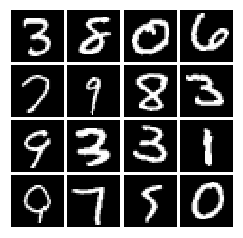

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha * x)


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [4]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, dim), minval=-1, maxval=1)


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [5]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        outputs = tf.layers.dense(x, 256, activation=leaky_relu)
        outputs = tf.layers.dense(outputs, 256, activation=leaky_relu)
        logits = tf.layers.dense(outputs, 1)
        return logits

## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        outputs = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        outputs = tf.layers.dense(outputs, 1024, activation=tf.nn.relu)
        img = tf.layers.dense(outputs, 784, activation=tf.tanh)
        return img

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [7]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake))
    D_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)) \
        + tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake))
    return D_loss, G_loss

# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [10]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

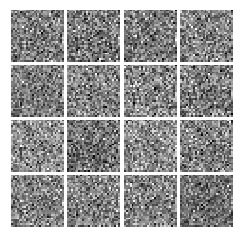


Iter: 0, D: 2.112, G:0.7677
Iter: 50, D: 0.3008, G:1.491
Iter: 100, D: 2.054, G:0.7326
Iter: 150, D: 0.8419, G:1.875
Iter: 200, D: 0.9863, G:1.119


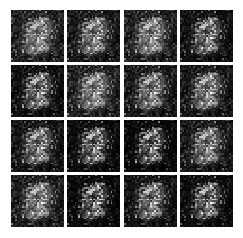


Iter: 250, D: 2.432, G:0.318
Iter: 300, D: 1.1, G:1.504
Iter: 350, D: 1.286, G:0.767
Iter: 400, D: 1.435, G:2.171
Iter: 450, D: 1.013, G:1.706


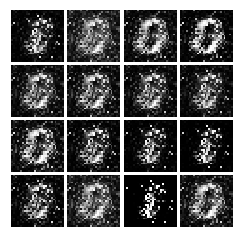


Iter: 500, D: 1.165, G:1.426
Iter: 550, D: 1.396, G:1.06
Iter: 600, D: 1.102, G:0.7274
Iter: 650, D: 1.215, G:0.9487
Iter: 700, D: 1.189, G:1.412


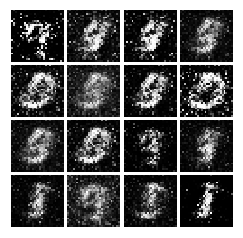


Iter: 750, D: 0.8933, G:1.683
Iter: 800, D: 1.059, G:1.243
Iter: 850, D: 1.565, G:2.989
Iter: 900, D: 1.3, G:1.301
Iter: 950, D: 1.371, G:1.145


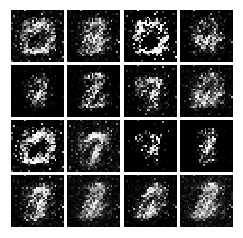


Iter: 1000, D: 1.242, G:1.345
Iter: 1050, D: 1.207, G:0.8871
Iter: 1100, D: 1.294, G:2.266
Iter: 1150, D: 1.66, G:0.05732
Iter: 1200, D: 1.247, G:1.202


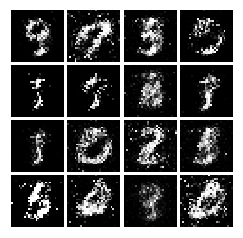


Iter: 1250, D: 1.297, G:0.9945
Iter: 1300, D: 1.136, G:1.001
Iter: 1350, D: 1.2, G:1.178
Iter: 1400, D: 1.216, G:1.153
Iter: 1450, D: 1.253, G:1.016


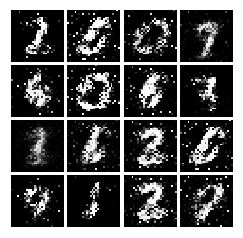


Iter: 1500, D: 1.133, G:1.956
Iter: 1550, D: 1.244, G:2.527
Iter: 1600, D: 1.246, G:1.2
Iter: 1650, D: 1.13, G:0.975
Iter: 1700, D: 1.269, G:1.027


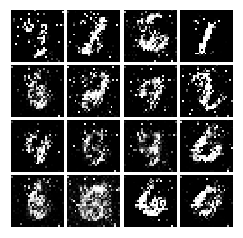


Iter: 1750, D: 1.294, G:0.9387
Iter: 1800, D: 1.379, G:0.9853
Iter: 1850, D: 1.355, G:0.92
Iter: 1900, D: 1.183, G:0.9533
Iter: 1950, D: 1.258, G:0.958


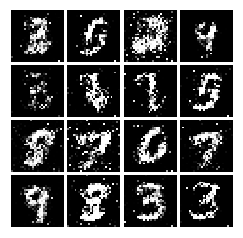


Iter: 2000, D: 1.394, G:0.8163
Iter: 2050, D: 1.265, G:0.9106
Iter: 2100, D: 1.26, G:0.8489
Iter: 2150, D: 1.264, G:1.005
Iter: 2200, D: 1.365, G:0.8649


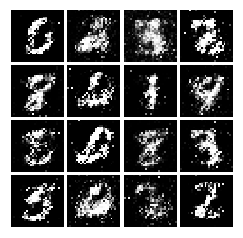


Iter: 2250, D: 1.371, G:0.9637
Iter: 2300, D: 1.367, G:0.9192
Iter: 2350, D: 1.287, G:0.8145
Iter: 2400, D: 1.296, G:0.9412
Iter: 2450, D: 1.372, G:0.7959


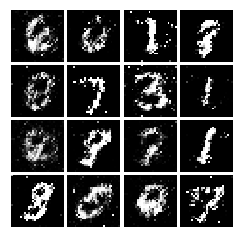


Iter: 2500, D: 1.329, G:0.865
Iter: 2550, D: 1.263, G:0.8281
Iter: 2600, D: 1.278, G:0.8565
Iter: 2650, D: 1.363, G:0.9122
Iter: 2700, D: 1.239, G:0.9031


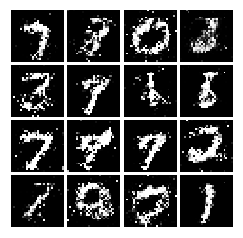


Iter: 2750, D: 1.354, G:0.9205
Iter: 2800, D: 1.235, G:0.8545
Iter: 2850, D: 1.244, G:0.9722
Iter: 2900, D: 1.346, G:0.7455
Iter: 2950, D: 1.298, G:0.8661


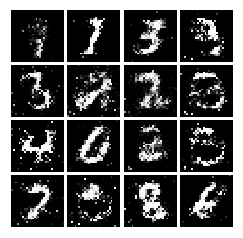


Iter: 3000, D: 1.327, G:0.7127
Iter: 3050, D: 1.257, G:0.9601
Iter: 3100, D: 1.253, G:0.8702
Iter: 3150, D: 1.292, G:0.8654
Iter: 3200, D: 1.294, G:0.7922


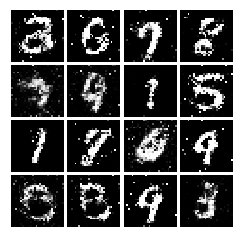


Iter: 3250, D: 1.316, G:0.8793
Iter: 3300, D: 1.255, G:0.7704
Iter: 3350, D: 1.348, G:0.9042
Iter: 3400, D: 1.281, G:0.7584
Iter: 3450, D: 1.305, G:0.8332


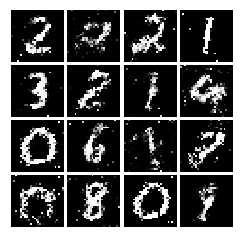


Iter: 3500, D: 1.323, G:0.8553
Iter: 3550, D: 1.333, G:0.778
Iter: 3600, D: 1.36, G:0.8371
Iter: 3650, D: 1.306, G:0.8171
Iter: 3700, D: 1.256, G:0.8252


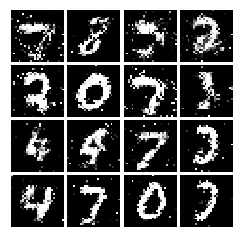


Iter: 3750, D: 1.357, G:0.8886
Iter: 3800, D: 1.292, G:0.9385
Iter: 3850, D: 1.294, G:0.8498
Iter: 3900, D: 1.335, G:0.8229
Iter: 3950, D: 1.328, G:0.811


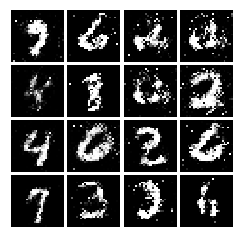


Iter: 4000, D: 1.333, G:0.7491
Iter: 4050, D: 1.31, G:0.7396
Iter: 4100, D: 1.33, G:0.9362
Iter: 4150, D: 1.304, G:0.8678
Iter: 4200, D: 1.309, G:0.9935


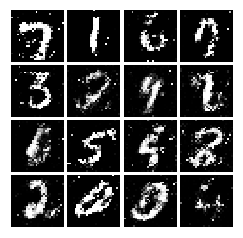


Iter: 4250, D: 1.34, G:0.8341
Final images


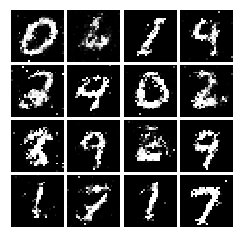

In [12]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)